In [2]:
import numpy as np

# making a 3d dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# svd gets all the principal components
x_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(x_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [3]:
# now we project the data set onto the plane defined by the principal components
w2 = Vt.T[:, :2]
x2d = x_centered.dot(w2)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x2d = pca.fit_transform(X)

In [5]:
# lists what proportion of the variance is due to each pc
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [6]:
# better to find out which components have the most variance, then reduce dimensionality after

# do pca without reduction, to get the variance ratios
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# then we could run it again
pca = PCA(n_components=d)
x2d = pca.fit_transform(X)

# even better we can just tell it directly how much variance we want to preserve
pca = PCA(n_components=.95)
x_reduced = pca.fit_transform(X)

In [7]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

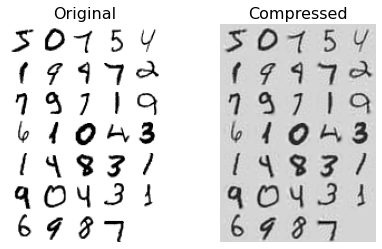

In [8]:
# we can also use pca for image compression, makes training on image datasets easier
# less memory, but features still there

from sklearn.datasets import fetch_openml
import matplotlib
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)
x = mnist["data"]
y = mnist["target"]

pca = PCA(n_components=154)
x_reduced = pca.fit_transform(x)
x_recovered = pca.inverse_transform(x_reduced)


plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(x[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(x_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [10]:
# incremental pca for when data doesn't fit in memory
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(x, n_batches):
    inc_pca.partial_fit(x_batch)
x_reduced = inc_pca

In [ ]:
# this code can run incremental pca on a large file on disk
#shape : tuple, optional
# The desired shape of the array. 
# If mode == 'r' and the number of remaining bytes after offset 
# is not a multiple of the byte-size of dtype, you must specify shape. 
# By default, the returned array will be 1-D with the number 
# of elements determined by file size and data-type.
# x_mm = np.memmap(file_path, dtype="float32", mode="readonly", shape=(m,n))
# batch_size = m // n_batches
# inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
# inc_pca.fit(x_mm)

In [11]:
# randomized PCA, finds an approximation of first d principal components
# faster than normal PCA, better to use when features are large and it doesn't need 
# to be the perfect components

rnd_pca = PCA(n_components=154, svd_solver="randomized")
x_reduced = rnd_pca.fit_transform(x)

In [ ]:
# kernel trick, project nonlinear data into a simpler space for dimensionality reduction
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
x_reduced = rbf_pca.fit_transform(x)

In [ ]:
# PCA is unsupervised, no way to pick the best number of components
# If you are using it with a supervised algorithm you can use the output of that to do grid search 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma" : np.linspace(0.03, 0.05, 10),
    "kpca__kernel" : ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(x, y)

print(grid_search.best_params_)

In [ ]:
# You can take the output of kernel PCA
# and project it back onto the original space to determine the reconstruction error
from sklearn.decomposition import KernelPCA
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)
x = mnist["data"]
y = mnist["target"]
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
x_reduced = rbf_pca.fit_transform(x)
# projection back to original space to get the "reconstruction image"
x_preimage = rbf_pca.inverse_transform(x_reduced)

from sklearn.metrics import mean_squared_error
mean_squared_error(x, x_preimage)

In [ ]:
# local linear embedding, does not rely on projections

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
x_reduced = lle.fit_transform(x)